In [171]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [172]:
TASK = 'convection' #'convection' nebo 'reaction'

# Metoda curriculum training pro 1D úlohu konvekce a reakce

**1D úloha konvekce:**
\begin{align*}
     \frac{\partial u}{\partial t}+\beta\frac{\partial u}{\partial x}&=0,\:\:x\in\langle 0,2\pi\rangle,\:\:t\in\langle 0,1  \rangle,\\
    u(x,0)&=\sin(x)+\cos(x),\\
    u(0,t)&=u(2\pi,t),
\end{align*}
kde $\beta>0$ je koeficient konvekce.
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\sin(x-\beta t)+\cos(x-\beta t). \end{equation}

**1D reakční úloha:**
\begin{align*}
     \frac{\partial u}{\partial t}-\rho u(1-u)&=0,\:\:x\in\langle 0,2\pi\rangle,\:\:t\in\langle 0,1\rangle,\\
    u(x,0)&=\mathrm{exp}\left(-\frac{\left(x-\frac{\pi}{2}\right)^2}{2\left(\frac{\pi}{4}\right)^2}\right)+\mathrm{exp}\left(-\frac{\left(x-\frac{3\pi}{2}\right)^2}{2\left(\frac{\pi}{4}\right)^2}\right)=:h(x),\\ 
    u(0,t)&=u(2\pi,t),
\end{align*}
kde $\rho\in\mathbb{R}$ je reakční koeficient.
Analytické řešení této úlohy je 
\begin{equation} u(x,t)=\frac{h(x)\mathrm{e}^{\rho t}}{h(x)\mathrm{e}^{\rho t}+1-h(x)}. \end{equation}

Parametr 'TASK' určuje, kterou úlohu budeme řešit. Zvolíme 'convection' nebo 'reaction'.

Použijeme NN s 5 skrytými vrstvami s aktivační funkcí $tanh()$ s 20 neurony v každé vrstvě.
Trénování provedeme na 1000 rovnoměrně rozložených bodech uvnitř oblasti $(-1,1)\times(0,1)$ a 150 bodech na hranici oblasti.
Trénování provedeme způsobem curriculum training. Pro každou hodnotu parametru provedeme 'epochs_per_param' epoch a pro poslendních 'double_epochs' hodnot parametru provedeme dvojnásobný počet epoch. Pro každou hodnotu paramteru nastavíme nejdříve optimalizátor Adam s learning rate $5\cdot 10^{-3}$ a pro posledních 'lbfgs_epochs' změníme optimalizátor na LBFGS s learning rate $10^{-1}$, maximálním počtem iterací v optimalizačním kroku $20$ a update history size $10$. Pro posledních 'double_epochs' hodnot změníme 'lbfgs_epochs' na 'final_lbfgs_epochs'.
Testování provedeme na 15000 náhodně rozložených bodech vygenerovaných metodou LHS.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `generate_inner_train_data()` pro generování trénovacích bodů uvnitř oblasti,
- `generate_boundaries()` pro generování trénovacích bodů na hranici oblasti,
- `plot_boundaries()` pro vykreslení trénovacích bodů,
- `compute_derivatives_2d()` pro výpočet derivací,
- `h_reaction()` pro výpočet počáteční podmínky úlohy reakce,
- `exact_solution_convection()` a `exact_solution_reaction()` pro výpočet analytického řešení,
- `enerate_test_data_lhs()` pro vygenerování testovacích dat metodou LHS.

**Krok 2:**
Definujeme funkce pro výpočet ztráty a funkce closure pro použití optimalizátoru LBFGS:
- `compute_loss_convection()` a `compute_loss_reaction()` pro výpočet ztrátové funkce,
- `closure_convection()` a `closure_reaction()` pro použití optimalizátoru LBFGS.

**Krok 3:**
Vygenerujeme trénovací data, inicializujeme model a optimalizátor Adam.

**Krok 4:**
Určíme hodnoty parametru, které použijeme v přůběhu curriculum trainig.
Spustíme trénovací smyčku.
Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 5:**
Vykreslíme aproximace řešení pomocí NN s využitím interpolace.
Vykreslíme řezy přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75.

**Krok 6:**
Výpočteme střední bodovou relativní a absolutní chybu aproximace řešení pomocí NN a vykreslíme bodovou relativní chybu aproximace řešení pomocí NN.

**Krok 7:**
Vykreslíme loss landscape perturbováním natrénovaného modelu přes první dva dominantní vlastní vektory Hessiánu a výpočtem odpovídajících hodnot ztrátové funkce.

In [173]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,t)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 1)  # Výstup je skalár u(x,t)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [174]:
# Krok 1.2: Funkce pro generování rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    t = torch.linspace(0, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    x = torch.linspace(0, 2*np.pi, int(torch.sqrt(torch.tensor(no_points)))) 
    T, X = torch.meshgrid(t, x)

    t = T.reshape(-1, 1)
    x = X.reshape(-1, 1)
    
    points_in = (t < 1 - 1e-3) & (t > 1e-3) & (x < 2*np.pi - 1e-3) & (x > 1e-3)

    t_train = t[points_in].view(-1, 1)
    x_train = x[points_in].view(-1, 1)

    return (t_train, x_train)

def generate_boundaries(no_points): # Body na hranici
    t_bottom = torch.linspace(0,1, no_points).view(-1, 1)
    x_bottom = torch.zeros_like(t_bottom)
    x_left = torch.linspace(0, 2*np.pi, no_points).view(-1, 1)
    t_left = torch.zeros_like(x_left)
    t_top = torch.linspace(0, 1, no_points).view(-1, 1)
    x_top = 2*np.pi*torch.ones_like(t_top)

    return (t_bottom, x_bottom, t_top, x_top, t_left, x_left)

In [175]:
# Krok 1.2: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    plt.figure(figsize=(12, 6))
    plt.scatter(t_bottom.numpy(), x_bottom.numpy(), label="Bottom",s=5, color='blue')
    plt.scatter(t_top.numpy(), x_top.numpy(), label="Top",s=5, color='green')
    plt.scatter(t_left.numpy(), x_left.numpy(), label="Left",s=5, color='red')
    plt.scatter(t_train.numpy(), x_train.numpy(), label="Trénovací data",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Hranice")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [176]:
# Krok 1.3: Funkce pro výpočet derivací
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    u = model(inputs)
    
    # První derivace
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (u, u_x, u_y, u_xx, u_yy)

In [177]:
# Krok 1.4: Funkce pro výpočet analytického řešení
def exact_solution_convection(t_data, x_data):
    u = torch.sin(x_data - BETA*t_data) + torch.cos(x_data - BETA*t_data)
    return u
def h_reaction(x):
    return torch.exp(-(x-torch.pi/2)**2/(2*(torch.pi/4)**2))+torch.exp(-(x-3*torch.pi/2)**2/(2*(torch.pi/4)**2))
def exact_solution_reaction(t_data, x_data):
    u = (h_reaction(x_data)*torch.exp(RHO*t_data))/(h_reaction(x_data)*torch.exp(RHO*t_data)+1-h_reaction(x_data))
    return u

In [178]:
# Krok 1.5: Funkce pro vygenerování testovacích dat v oblasti (i na její hranici)
def generate_test_data_lhs(no_points):
    # Body uvnitř a na hranici oblasti
    no_inside_points = int(no_points * 0.97)
    no_boundary_points = no_points - no_inside_points

    # Funkce pro generování pomocí LHS
    def latin_hypercube_sampling(num_samples, dim):
        # Mřížka intervalů
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Vnitřní body
    lhs_inside = latin_hypercube_sampling(no_inside_points, 2)
    x_inside = lhs_inside[:, 0:1]
    y_inside = lhs_inside[:, 1:2] * 2 * np.pi  # Transform y to range (0, 2*pi)

    # Body na hranici
    lhs_boundary = latin_hypercube_sampling(no_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_boundary_points,)) 
    x_boundary = torch.zeros(no_boundary_points, 1)
    y_boundary = torch.zeros(no_boundary_points, 1)

    # Přiřazení bodů na hranice: 0 -> horní, 1 -> dolní, 2 -> levá, 3 -> pravá
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0]
    y_boundary[side_assignments == 0] = 2 * np.pi  # Top boundary

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1]
    y_boundary[side_assignments == 1] = 0  # Bottom boundary

    x_boundary[side_assignments == 2] = 0  # Left boundary
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2] * 2 * np.pi

    x_boundary[side_assignments == 3] = 1  # Right boundary
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3] * 2 * np.pi

    # Spojení bodů
    x_test = torch.cat((x_inside, x_boundary), dim=0)
    y_test = torch.cat((y_inside, y_boundary), dim=0)

    return (x_test, y_test)

In [179]:
# Krok 2.1: Definice ztrátové funkce
def compute_loss_convection(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    # PDR ztráta
    u_train, u_t_train, u_x_train, _, _ = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((u_t_train + BETA * u_x_train)**2)
    
    # Ztráta na hranici
    u_left = model(torch.cat([t_left, x_left], dim=1))
    left_loss = torch.mean((u_left - (torch.sin(x_left)+torch.cos(x_left)))**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    top_bottom_loss = torch.mean((u_bottom - u_top)**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_bottom_loss
    return total_loss

def compute_loss_reaction(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    # PDR ztráta
    u_train, u_t_train, u_x_train, u_tt_train, u_xx_train = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((u_t_train - RHO*u_train*(torch.ones_like(u_train)-u_train))**2)
    
    # Ztráta na hranici
    u_left = model(torch.cat([t_left, x_left], dim=1))
    left_loss = torch.mean((u_left - h_reaction(x_left))**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    top_bottom_loss = torch.mean((u_bottom - u_top)**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_bottom_loss
    return total_loss

In [180]:
# Krok 2.2: Funkce closure pro použití optimalizátoru LBFGS
def closure_convection():
    optimizer.zero_grad()

    loss = compute_loss_convection(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

    loss.backward(retain_graph=True)
    return loss
def closure_reaction():
    optimizer.zero_grad()

    loss = compute_loss_reaction(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

    loss.backward(retain_graph=True)
    return loss

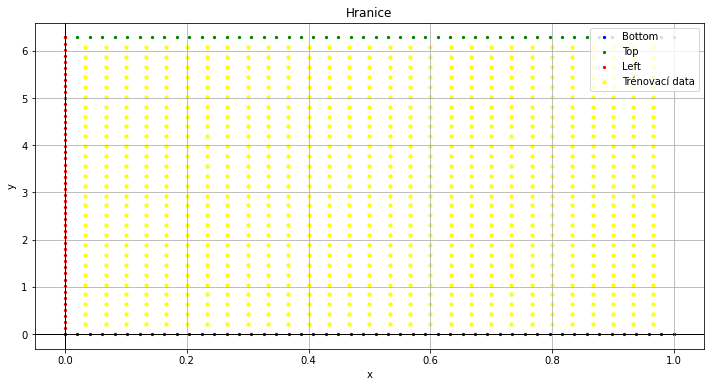

In [181]:
# Krok 3.1: Vygenerování trénovacích dat
t_train, x_train = generate_inner_train_data(1000) # Body uvnitř oblasti
t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50) # Body na hranici oblasti

plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left) # Vykreslení trénovacích dat

In [182]:
# Krok 3.2: Inicializace modelu a optimalizátoru
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

In [183]:
# Krok 4.1: Určení hodnot parametru
# Pro úlohu konvekce (hodnoty beta):
# params = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]
params = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
# params = [0.1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
# params = [0.1, 1, 2, 4, 6, 8, 10]
# params = [0.1, 0.5, 1]
# Pro úlohu reakce (hodnoty rho):
# params = [0.1, 0.2, 0.5, 0.8, 1.1, 1.4, 1.7, 2]
# params = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 4]
# params = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
# params = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
# params = [0.1, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

In [184]:
# Krok 4.2: Trénovací smyčka
lbfgs_epochs = 500
final_lbfgs_epochs = 650 # Počet epoch s LBFGS optimalizátorem pro posledních 'double_epochs' hodnot
double_epochs = 5
i = 1
epochs_per_param = 800
c = 0
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
epochs = int(epochs_per_param * len(params)) + double_epochs*epochs_per_param
best_loss = float('inf')
best_model_state_dict = None
if TASK == 'convection':
    compute_loss = compute_loss_convection
    closure = closure_convection
    exact_solution = exact_solution_convection
    BETA = params[0]
elif TASK == 'reaction':
    compute_loss = compute_loss_reaction
    closure = closure_reaction
    exact_solution = exact_solution_reaction
    RHO = params[0]
    
for epoch in range(epochs):
    if (((epoch + 1) % epochs_per_param) <= (epochs_per_param-lbfgs_epochs)) & (((epoch + 1) % epochs_per_param)!=0):
        optimizer.zero_grad()
    
        # Výpočet ztráty
        loss = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
    else:
        loss = optimizer.step(closure)

    if ((epoch + 1) % epochs_per_param) == (epochs_per_param-lbfgs_epochs):
        if i < len(params)-(double_epochs-1):
            print(f"Změna optimalizátoru v epoše {epoch + 1}")
            model.load_state_dict(best_model_state_dict)
            optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)
        else:
            if c == 1:
                print(f"Změna optimalizátoru v epoše {epoch + 1}")
                model.load_state_dict(best_model_state_dict)
                optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)

    loss_values.append(loss.detach().numpy())

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state_dict = model.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')
    if ((epoch + 1) % epochs_per_param == 0) & ((epoch+1) != epochs):
        if i < len(params)-(double_epochs-1):
            if TASK == 'convection':
                BETA = params[i]
            elif TASK == 'reaction':
                RHO = params[i]
            optimizer = optim.Adam(model.parameters(), lr=5e-3)
            i += 1
            best_model_state_dict = None
            best_loss = float('inf')
        else:
            lbfgs_epochs = final_lbfgs_epochs
            if c==0:
                c = 1
            else:
                if TASK == 'convection':
                    BETA = params[i]
                elif TASK == 'reaction':
                    RHO = params[i]
                optimizer = optim.Adam(model.parameters(), lr=5e-3)
                i += 1
                c = 0
                best_model_state_dict = None
                best_loss = float('inf')

        if TASK == 'convection':
            print(f'Změna parametru beta na {BETA}')
        elif TASK == 'reaction':
            print(f'Změna parametru rho na {RHO}')

Epocha 100/17600, Ztráta: 0.03262167051434517
Epocha 200/17600, Ztráta: 0.009284607134759426
Změna optimalizátoru v epoše 300
Epocha 300/17600, Ztráta: 0.0058906893245875835
Epocha 400/17600, Ztráta: 0.00011249029194004834
Epocha 500/17600, Ztráta: 4.9218877393286675e-05
Epocha 600/17600, Ztráta: 4.9218877393286675e-05
Epocha 700/17600, Ztráta: 4.9218877393286675e-05
Epocha 800/17600, Ztráta: 4.9218877393286675e-05
Změna parametru beta na 1
Epocha 900/17600, Ztráta: 0.04315357655286789
Epocha 1000/17600, Ztráta: 0.005601780489087105
Změna optimalizátoru v epoše 1100
Epocha 1100/17600, Ztráta: 0.00276227667927742
Epocha 1200/17600, Ztráta: 8.087128662737086e-05
Epocha 1300/17600, Ztráta: 4.7216461098287255e-05
Epocha 1400/17600, Ztráta: 4.7216461098287255e-05
Epocha 1500/17600, Ztráta: 4.7216461098287255e-05
Epocha 1600/17600, Ztráta: 4.7216461098287255e-05
Změna parametru beta na 2
Epocha 1700/17600, Ztráta: 0.1936660259962082
Epocha 1800/17600, Ztráta: 0.007908609695732594
Změna optim

Nejlepší epocha 4448, Ztráta: 1.8330145394429564e-05


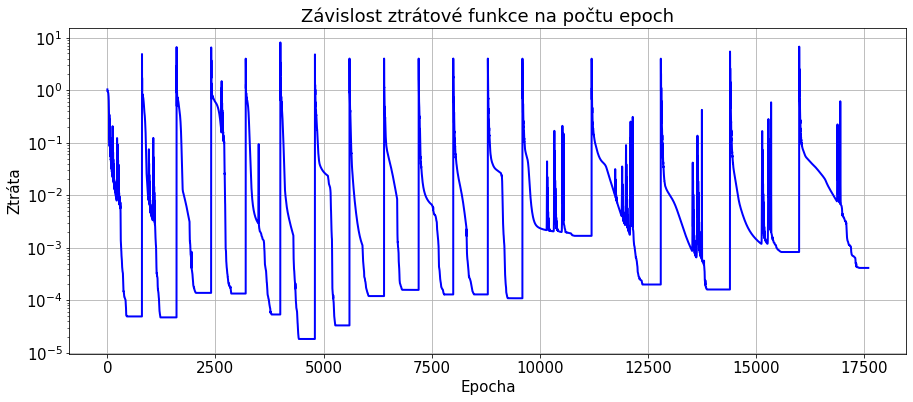

In [185]:
# Krok 4.3: Graf znázorňující závislost ztráty na počtu epoch
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(15, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch', fontsize=18)
plt.xlabel('Epocha', fontsize=15)
plt.ylabel('Ztráta', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

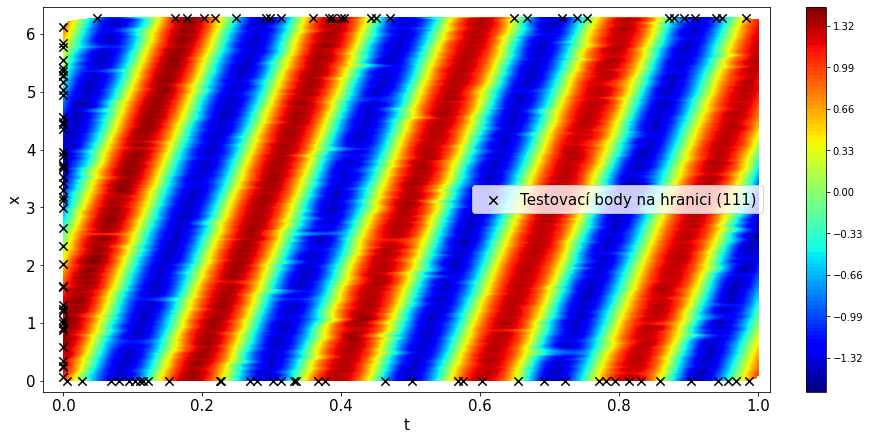

In [186]:
# Krok 5.1: Vykreslení aproximace NN řešení zadané úlohy ve 2D grafu s interpolací
t_test, x_test = generate_test_data_lhs(5000)
with torch.no_grad():
    inputs = torch.cat([t_test, x_test], dim=1)
    u_pred = model(inputs) 

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = u_pred.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
# Vykreslení bodů na hranici
boundary_mask = (x == 0) | (x == 2*np.pi) | (t == 0)
t_boundary = t[boundary_mask]
x_boundary = x[boundary_mask]
no_bound_points = len(t_boundary)
ax.scatter(t_boundary, x_boundary, color="black", s=70, label=f"Testovací body na hranici ({no_bound_points})", marker="x")

ax.legend(fontsize=15)
x_padding = 0.03 * (x_boundary.max() - x_boundary.min())  # Přidání okrajů
t_padding = 0.03 * (t_boundary.max() - t_boundary.min())
ax.set_xlim(t_boundary.min() - t_padding, t_boundary.max() + t_padding)
ax.set_ylim(x_boundary.min() - x_padding, x_boundary.max() + x_padding)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

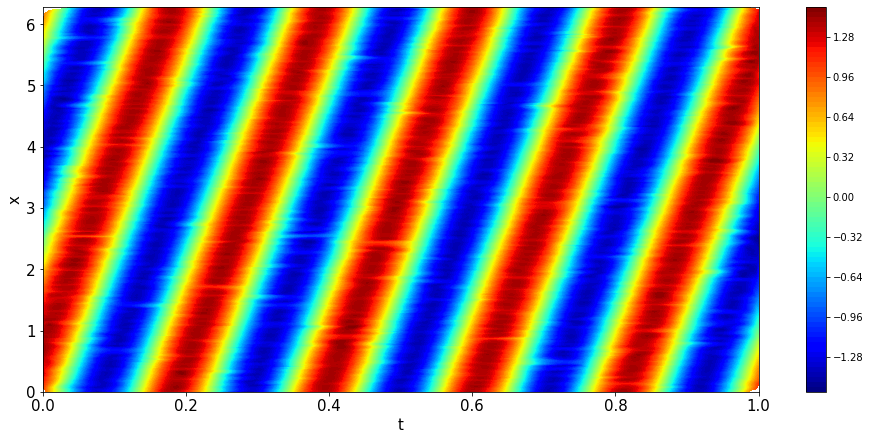

In [187]:
# Krok 5.2: Vykreslení přesného řešení
true_values = exact_solution(t_test, x_test)

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = true_values.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [188]:
# Krok 5.3: Definice funkce pro vykreslení řezů aproximace řešení pomocí NN a přesného řešení
def plot_solution_cut_with_exact(t_fixed, t_test, x_test, u_pred):
    t = t_test.detach().cpu().numpy().squeeze()
    x = x_test.detach().cpu().numpy().squeeze()
    z = u_pred.detach().cpu().numpy().squeeze()

    # Body poblíž řezu
    tolerance = 1e-3
    mask = np.abs(t - t_fixed) < tolerance
    x_filtered = x[mask]
    z_filtered = z[mask]

    # Odstranění duplicitních dat
    x_filtered, unique_indices = np.unique(x_filtered, return_index=True)
    z_filtered = z_filtered[unique_indices]

    # Interpolace
    x_interp = np.linspace(x_filtered.min(), x_filtered.max(), 500)
    z_interp = griddata(x_filtered, z_filtered, x_interp, method="cubic")

    # Přesné řešení
    t_fixed_tensor = torch.full((500, 1), t_fixed)
    x_interp_tensor = torch.tensor(x_interp, dtype=torch.float32).view(-1, 1)
    exact_z = exact_solution(t_fixed_tensor, x_interp_tensor)
    exact_z = exact_z.detach().cpu().numpy().squeeze()

    # Vykreslení predikcí a přesného řešení
    plt.figure(figsize=(6, 6))
    plt.plot(x_interp, exact_z, label="Analytické řešení", color="blue", linewidth=5)
    plt.plot(x_interp, z_interp, label=f"Predikce NN (t = {t_fixed:.3f})", color="red",linestyle="--", linewidth=5)
    plt.title(f"Řez v t = {t_fixed:.3f}", fontsize=18)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("u", fontsize=15)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 
    plt.grid()
    plt.show()

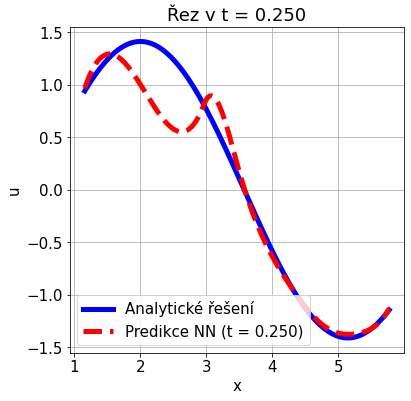

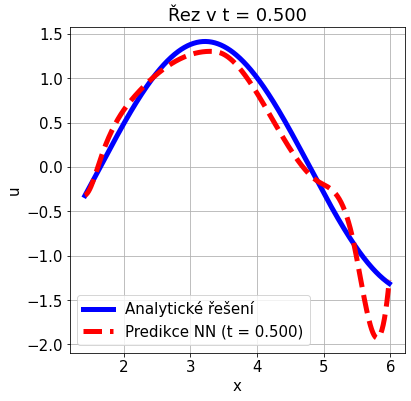

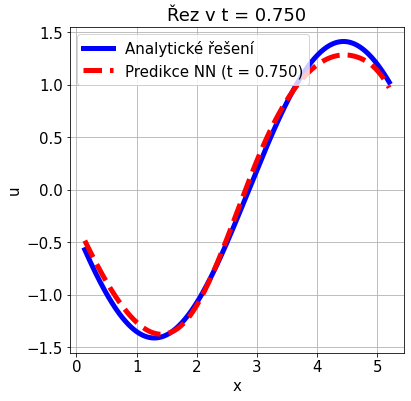

In [189]:
# Krok 5.4: Vykreslení řezů přesného a aproximovaného řešení v t=0,25; t=0,5; t=0,75
plot_solution_cut_with_exact(0.25, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.5, t_test, x_test, u_pred)
plot_solution_cut_with_exact(0.75, t_test, x_test, u_pred)

In [190]:
# Krok 6.1: Výpočet střední bodové relativní a absolutní chyby aproximace řešení NN
true_values = exact_solution(t_test, x_test)

pws_absolute_errors = torch.norm(u_pred - true_values, dim=1)
mean_absolute_error = torch.mean(pws_absolute_errors)

F = torch.max(torch.abs(true_values))
absolute_errors = torch.abs(u_pred - true_values)
relative_errors_F = absolute_errors / F
mean_relative_error_F = torch.mean(relative_errors_F)

print(f'Střední bodová absolutní chyba: {mean_absolute_error.item():.6f}')
print(f'Střední bodová relativní chyba: {mean_relative_error_F.item():.6f}')

Střední bodová relativní chyba: 0.151558
Střední bodová absolutní chyba: 0.037398


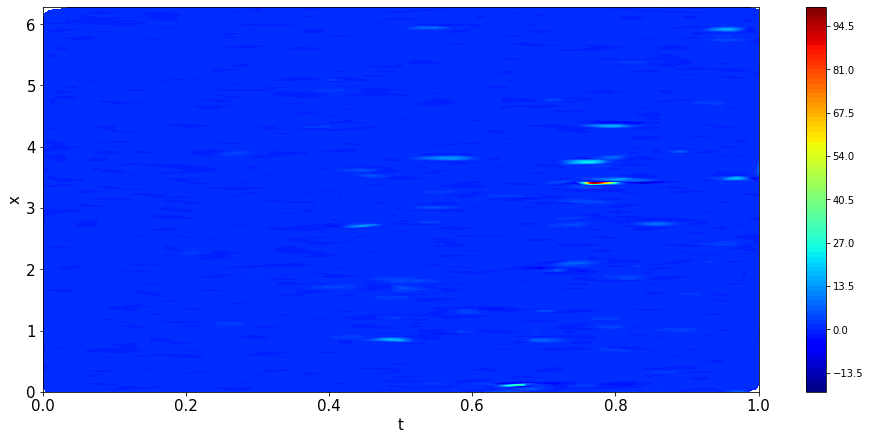

In [191]:
# Krok 6.2: Výpočet a vykreselní relativní pointwise chyby aproximace řešení NN
pointwise_relative_error = torch.abs((u_pred - true_values) / (true_values))

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()
z = pointwise_relative_error.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(0, 2*np.pi, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)
grid_z = griddata((t, x), z, (grid_t, grid_x), method="cubic")

# Vykreslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("x", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

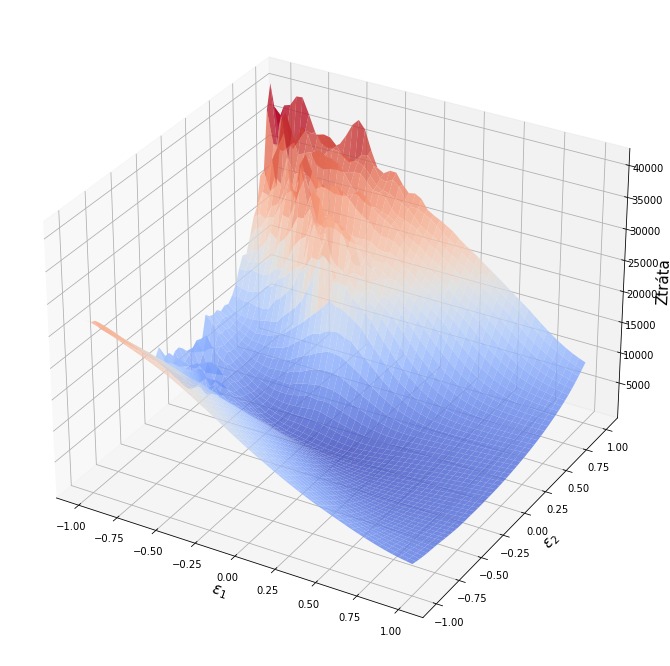

In [170]:
# Krok 7: Vykreslení loss landscape
def compute_hessian(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, loss_fn):
    # Výpočet Hessovy matice modelu vzhledem ke ztrátě
    params = list(model.parameters())
    num_params = sum(param.numel() for param in params)
    hessian = torch.zeros(num_params, num_params)  # Alokace matice
    
    # Výpočet ztráty a gradientu
    loss = loss_fn(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)
    grads = torch.autograd.grad(loss, params, create_graph=True)
    
    # Převedení do jednoho vektoru
    grads_flat = torch.cat([g.contiguous().view(-1) for g in grads])
    
    # Výpočet derivací 2 rádu
    for i, grad in enumerate(grads_flat):
        row_grads = torch.autograd.grad(grad, params, retain_graph=True, allow_unused=True)
        row_grads_flat = torch.cat([(g.contiguous().view(-1) if g is not None else torch.zeros_like(p).view(-1))for g, p in zip(row_grads, params)])
        hessian[i, :] = row_grads_flat
    
    return hessian

def plot_loss_landscape(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, perturb_scale=0.1, num_points=50):
    # Uložení původních parametrů
    original_params = [param.clone() for param in model.parameters()]
    
    # Výpočet Hessiánu
    loss_fn = compute_loss  # Ztrátová funkce
    hessian = compute_hessian(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, loss_fn)
    
    # Úprava Hessiánu pro výpočet vlastních čísel
    hessian_flat = hessian.cpu().detach().numpy()
    
    # Výpočet vlastních čísel a vektorů
    eigenvalues, eigenvectors = np.linalg.eigh(hessian_flat)
    
    # První dominantní dva vlastní vektory a čísla
    dominant_eigenvectors = eigenvectors[:, -2:]  # Poslední dva vektory
    
    # Normalizace vlastních vektorů
    perturb_eigenvector_1 = torch.tensor(dominant_eigenvectors[:, 0] / np.linalg.norm(dominant_eigenvectors[:, 0]), dtype=original_params[0].dtype, device=original_params[0].device)
    perturb_eigenvector_2 = torch.tensor(dominant_eigenvectors[:, 1] / np.linalg.norm(dominant_eigenvectors[:, 1]), dtype=original_params[0].dtype, device=original_params[0].device)
    
    # Mřížka perturbací
    epsilon_1 = np.linspace(-perturb_scale, perturb_scale, num_points)
    epsilon_2 = np.linspace(-perturb_scale, perturb_scale, num_points)
    epsilon_1, epsilon_2 = np.meshgrid(epsilon_1, epsilon_2)
    
    # Pro uložení ztrát
    losses = np.zeros_like(epsilon_1)
    
    # Výpočet ztráty pro každou kombinaci (epsilon_1, epsilon_2)
    for i in range(num_points):
        for j in range(num_points):
            # Perturbace parametrů ve směru vlastních vektorů
            with torch.no_grad():
                start_idx = 0
                for k, param in enumerate(model.parameters()):
                    # Výpočet počtu prvků v daném parametru
                    num_elements = param.numel()
                    
                    # Extrakce podstatné části vektoru
                    perturbation = (epsilon_1[i, j] * perturb_eigenvector_1[start_idx:start_idx + num_elements] + epsilon_2[i, j] * perturb_eigenvector_2[start_idx:start_idx + num_elements])
                    
                    # Upravení tvaru perturbace
                    perturbation = perturbation.view(param.size())
                    
                    # Přidání perturbace
                    param.add_(perturbation)
                    
                    # Update startovacího indexu
                    start_idx += num_elements
            
            # Výpočet ztráty
            losses[i, j] = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left).item()
            
            # Reset parametrů na původní
            with torch.no_grad():
                for k, param in enumerate(model.parameters()):
                    param.copy_(original_params[k])

    
    # Vykreslení loss landscape
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(epsilon_1, epsilon_2, losses, cmap='coolwarm', edgecolor='none', alpha=0.8)
    ax.set_xlabel(r'$\epsilon_1$', fontsize=15)
    ax.set_ylabel(r'$\epsilon_2$', fontsize=15)
    ax.set_zlabel('Ztráta', fontsize=15)
    #plt.title(rf'Loss Landscape pro $\beta = {BETA}$', fontsize=18)
    plt.show()

plot_loss_landscape(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left, 1, 50)